<a href="https://colab.research.google.com/github/ivychung/plant-ML/blob/final-updates/AlexNet_2_classes_real_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ========================================
# File Name : AlexNet_2_classes_real_images.ipynb
#
# Creation Date : Feburary 22, 2022
#
# Created By : Ivy Chung and Anoushka Gupta
# ========================================

"""Initializing required libraries"""

# so that we can mount google drive
from google.colab import drive

# numerical computation and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import gc # garbage collector to free objects on demand

# file manipulation
import zipfile
import os
import shutil

# load and show an image with Pillow
from PIL import Image

# load and display an image with Matplotlib
%matplotlib inline
from matplotlib import image
from matplotlib import pyplot
from numpy import asarray

# sklearn tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold

# tensorflow tools
from tensorflow import keras
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.layers as layers

# other
import cv2

from tensorflow.keras import backend as K
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from sklearn.metrics import accuracy_score

from random import randint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Extract the dataset zip file
dataset_name = 'tomato-real-images-resized'

drive_dataset_address = '/content/drive/Shareddrives/Anoushka && Ivy/Senior Design 2021_2022_Ivy and Anoushka/dataset/'
working_dataset_address = os.path.join('/tmp/', dataset_name)

zip_ref = zipfile.ZipFile(drive_dataset_address + dataset_name + '.zip', 'r')
zip_ref.extractall('/tmp/') # Extracts the files into the appropriate folder
zip_ref.close()

In [ ]:
# Removes the __MACOSX file that comes with zipping a file on Mac
try:
  shutil.rmtree('/tmp/__MACOSX')
except:
  pass

In [ ]:
# Getting class names

# Function to extract all sub- file/directory names
def read_filenames(dir_path, file_bool = True):
  if file_bool: # list all files in the folder
    return [f for f in os.listdir(dir_path) \
            if os.path.isfile(os.path.join(dir_path, f))]
  if not file_bool: # list all subfolders in the folder
    return [f for f in os.listdir(dir_path) \
            if os.path.isdir(os.path.join(dir_path, f))]
            
classes = read_filenames(working_dataset_address,file_bool = False)
classes

['Healthy', 'Unhealthy']

In [ ]:
# global variables to keep track of how many classes we have
CLASS_SIZE = len(classes)

In [ ]:
# Collect all image names
img_names = [read_filenames(os.path.join(working_dataset_address, classes[i])) for i in range(CLASS_SIZE)]

# Row length should be the number of classes
print("Row Length", len(img_names))

# collect each column length
row_lengths = []

for i in range(CLASS_SIZE):
  row_lengths.append(len(img_names[i]))

print("column length", row_lengths)

Row Length 2
column length [18, 19]


In [ ]:
# resize and standardize images
def pre_process_image(image):
    image=tf.image.per_image_standardization(image)
    image=tf.image.resize(image,(64,64))
    return image

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:
# making np array of the images in pixel values
x_ori = []
x = []
y = []

# read the images into an array 
for i in range(CLASS_SIZE):
  for j in range(len(img_names[i])):
    img_path = os.path.join(working_dataset_address, classes[i], img_names[i][j])
    try:
      img = Image.open(img_path)
      data = asarray(img) # convert image to numpy array
      data_resized = pre_process_image(data)
      aug_data = tf.cast(tf.expand_dims(data_resized, 0), tf.float32)
      for k in range(9):
        augmented_image = data_augmentation(aug_data)
        x_ori.append(data)
        x.append(tf.squeeze(augmented_image))
        y.append(classes[i])
    except:
      pass


print("Total image count:", len(x))
print("Total label count:", len(y))
x = np.asarray(x)
y = np.asarray(y).ravel()

Total image count: 315
Total label count: 315


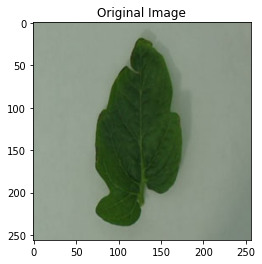

Healthy


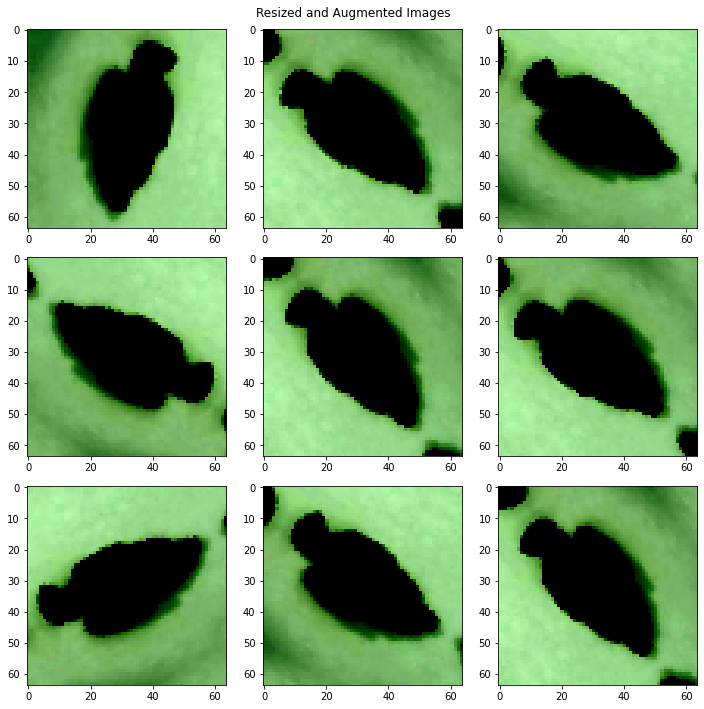

In [ ]:
# checking image processing with one image
i = 0

fig = plt.figure()
plt.imshow(x_ori[i])
plt.title("Original Image")
plt.show()

print(y[i])


fig, axs = plt.subplots(3, 3,figsize=(10,10))
for i in range(9):
  row = int(i/3)
  col = i%3
  img = x[i]
  img = np.clip(img, 0, 1)
  axs[row,col].imshow(img)


fig.suptitle('Resized and Augmented Images')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [ ]:
# Now we need to split the data into a training and a validating dataset
x_train, x_test, y_train, y_test = train_test_split(x, y,
    test_size=0.2, shuffle = True, random_state = 8)

In [ ]:
# convert our data vectors to the desired format
# Our x data vectors are four-dimensional, just as we wanted

# convert the labels be to int-encoded 
label_encoder = LabelEncoder()

# function to convert y data vectors int encoded class matrices
def convert_to_categorical(y_train, y_test, oneHot = True, makeArray = False):
  y_train = label_encoder.fit_transform(y_train)
  y_test = label_encoder.fit_transform(y_test)
  
  if oneHot:
    y_train = keras.utils.to_categorical(y_train, CLASS_SIZE)
    y_test = keras.utils.to_categorical(y_test, CLASS_SIZE)

  if makeArray:
    y_train = np.array([np.array([y]) for y in y_train])
    y_test = np.array([np.array([y]) for y in y_test])
  
  return y_train, y_test

# convert the label formatting
y_train, y_test = convert_to_categorical(y_train, y_test, False, True)

In [ ]:
print(type(y_train), type(y_train[0]))

# check our final shape
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
x_train shape: (252, 64, 64, 3)
x_test shape: (63, 64, 64, 3)
y_train shape: (252, 1)
y_test shape: (63, 1)


In [ ]:
# takes the train, test, and validation dataset partitions and returns a corresponding TensorFlow Dataset representation

train_ds=tf.data.Dataset.from_tensor_slices((x_train,y_train))
test_ds=tf.data.Dataset.from_tensor_slices((x_test,y_test))

# input pipeline
train_ds_size=tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size=tf.data.experimental.cardinality(test_ds).numpy()
print('Train size:', train_ds_size)
print('Test size:', test_ds_size)

Train size: 252
Test size: 63


In [ ]:
# using the optimal batch size
batch_size = 1

def process_image(image, label):
    image=tf.image.per_image_standardization(image)
    image=tf.image.resize(image,(64,64))
    return image, label

# re-organize images
train_ds_sized=(train_ds
        .shuffle(buffer_size=test_ds_size)
        .batch(batch_size=batch_size,drop_remainder=True)
        )
test_ds_sized=(test_ds
      .shuffle(buffer_size=test_ds_size)
      .batch(batch_size=batch_size,drop_remainder=True)
      )

In [ ]:
def create_model():
  AlexNet_model=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10,activation='softmax')  

  ])
  return AlexNet_model

In [ ]:
AlexNet_model = create_model()
AlexNet_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']    
)
# AlexNet_model.summary()

In [ ]:
# use callback to find the optimal number of epochs to use
earlystopping = EarlyStopping(monitor ="val_accuracy", 
                                        mode ="max", patience = 5, 
                                        restore_best_weights = True)
# fit the model
history = AlexNet_model.fit(
  train_ds_sized,
  epochs = 50,
  validation_data = test_ds_sized,
  validation_freq = 1,
  callbacks =[earlystopping]
  )
    
print('Test accuracy Score = ',np.max(history.history['val_accuracy']))

Epoch 1/50
252/252 [==============================] - 4s 6ms/step - loss: 1.3029 - accuracy: 0.5000 - val_loss: 1.0363 - val_accuracy: 0.4762
Epoch 2/50
252/252 [==============================] - 1s 5ms/step - loss: 1.0905 - accuracy: 0.5040 - val_loss: 0.8498 - val_accuracy: 0.5238
Epoch 3/50
252/252 [==============================] - 1s 5ms/step - loss: 0.9571 - accuracy: 0.4841 - val_loss: 0.8348 - val_accuracy: 0.5714
Epoch 4/50
252/252 [==============================] - 1s 5ms/step - loss: 0.8759 - accuracy: 0.4960 - val_loss: 0.8193 - val_accuracy: 0.5873
Epoch 5/50
252/252 [==============================] - 1s 5ms/step - loss: 0.8262 - accuracy: 0.5119 - val_loss: 0.8425 - val_accuracy: 0.5238
Epoch 6/50
252/252 [==============================] - 1s 5ms/step - loss: 0.8542 - accuracy: 0.5119 - val_loss: 0.8354 - val_accuracy: 0.5238
Epoch 7/50
252/252 [==============================] - 1s 5ms/step - loss: 0.8353 - accuracy: 0.4881 - val_loss: 0.8181 - val_accuracy: 0.5238
Epoch 

In [ ]:
AlexNet_model.history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

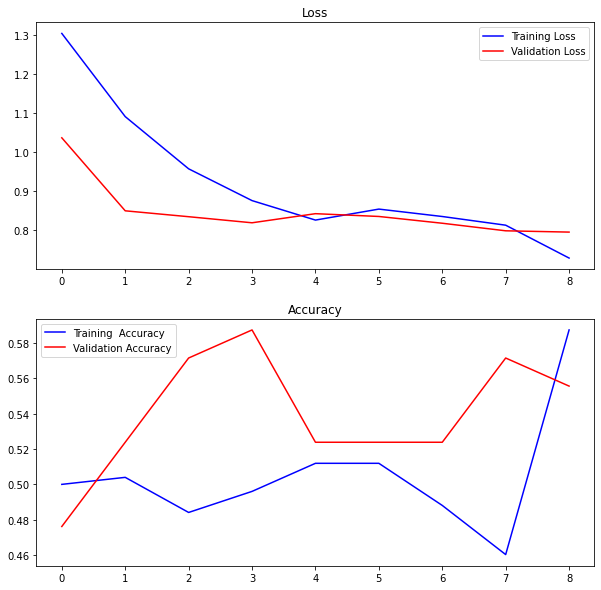

In [ ]:
f,ax=plt.subplots(2,1,figsize=(10,10)) 

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(AlexNet_model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(AlexNet_model.history.history['val_loss'],color='r',label='Validation Loss')
ax[0].title.set_text('Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(AlexNet_model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(AlexNet_model.history.history['val_accuracy'],color='r',label='Validation Accuracy')
ax[1].title.set_text('Accuracy')

ax[0].legend()
ax[1].legend()


In [ ]:
print("Evaluate loaded model")
results = AlexNet_model.evaluate(test_ds_sized)
print("test loss", results[0])
print("test accuracy", results[1])

Evaluate loaded model
63/63 [==============================] - 0s 3ms/step - loss: 0.8193 - accuracy: 0.5873
test loss 0.8192558288574219
test accuracy 0.5873016119003296


In [ ]:
# testing saving trained model 
base_save_path = '/content/drive/Shareddrives/Anoushka && Ivy/Senior Design 2021_2022_Ivy and Anoushka/Trained Models/'
save_path = base_save_path+'Tomato 2 Classes AlexNet realimages/'
AlexNet_model.save(save_path)

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Anoushka && Ivy/Senior Design 2021_2022_Ivy and Anoushka/Trained Models/Tomato 2 Classes AlexNet realimages/assets


In [ ]:
# testing loading model
AlexNet_model = keras.models.load_model(save_path)

Generate predictions for sample
Original Image


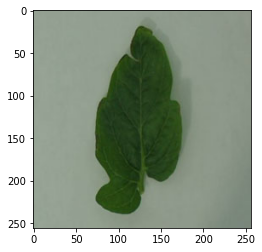

Input Image


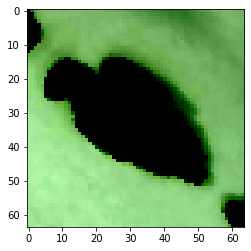

Prediction: Unhealthy
Actual: Unhealthy


In [ ]:
print("Generate predictions for sample")

i = randint(0,len(x[i]))

print("Original Image")
img = x_ori[i]
plt.imshow(img)
plt.show()

print("Input Image")
img = x[i]
img = np.clip(img, 0, 1)
plt.imshow(img)
plt.show()

# making the prediction
img = tf.expand_dims(img, axis=0)

y_pred = AlexNet_model.predict(img)
prediction = y_pred.argmax()

print('Prediction:', classes[prediction])
print('Actual:', classes[prediction])

Generate predictions for sample
Input Image


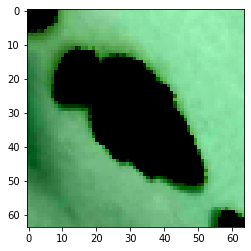

Prediction: Unhealthy
Actual: Unhealthy


In [ ]:
print("Generate predictions for sample")

i = randint(0,len(x_test))

print("Input Image")
img = x_test[i]
img = np.clip(img, 0, 1)
plt.imshow(img)
plt.show()

# making the prediction
img = tf.expand_dims(img, axis=0)

y_pred = AlexNet_model.predict(img)
prediction = y_pred.argmax()

print('Prediction:', classes[prediction])
print('Actual:', classes[prediction])

In [ ]:
# real_images_drive_dataset_address = '/content/drive/Shareddrives/Anoushka && Ivy/Senior Design 2021_2022_Ivy and Anoushka/images-real/'
# img_name = 'nvcamtest_20248_s00_00000.jpg'

# img = Image.open(real_images_drive_dataset_address+img_name)
# plt.imshow(img)
# plt.show()
# img = asarray(img) # convert image to numpy array

# img,lab = process_image(img,1)
# # plt.imshow(img)
# # plt.show()

# img = tf.expand_dims(img, axis=0)

# y_pred_img = AlexNet_model.predict(img)
# prediction = y_pred_img.argmax()

# print('\nPrediction:', classes[prediction])